In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import glob
import math
import os.path

import numpy as np
import numpy.random as rnd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy
import scipy.special

plt.rc("font", **{"size": 20})
plt.rc("lines", linewidth=4.0)
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2

fig_size = 6

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
"""
We draw one teacher from the hypersphere in D dimensions and normalise its weight vector.
"""

# input dimension
D = 400


# Choose a random teacher
w_teacher = rnd.randn(D)
w_teacher /= np.sqrt(w_teacher @ w_teacher / D)
unit_teacher = w_teacher/np.linalg.norm(w_teacher)
W = np.linalg.norm(w_teacher)

def test_accuracy(w_stu, w_tea, T):
    """
    Returns the test accuracy for a teacher-student pair with the given weight vectors.
    """
    angle = (w_stu @ w_tea / 
             np.linalg.norm(w_stu) / np.linalg.norm(w_tea))
    return (1 - 1 / np.pi * np.arccos(angle))**T

def test_accuracy_op(Q, R, T):
    """
    Returns the test accuracy for a teacher-student pair with the given overlaps.
    """
    return (1 - 1 / np.pi * np.arccos(R * np.sqrt(D/Q)/W))**T

In [7]:
"""
Calculates the expected magnitude of a standard normal isotropic vector in D dimensions
"""
def magnitude(n):
  if n % 2 == 0:
    a, b = n+1, n/2
    c = 1
    for i in range(int(n/2-1)):
      a, b = a-2, b-1
      c = c*a/(2*b)
    return np.sqrt(np.pi/2)*c
  else:
    a, b = (n+1)/2, n
    c = 1
    for i in range(int((n-1)/2)):
      a, b = a-1, b-2
      c = c*2*a/b
    return np.sqrt(2/np.pi)*c

In [8]:
"""
Experimentation: original case
"""

Ts = [1, 2, 3, 10]
# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student = dict()
w_student = rnd.randn(D)
for T in Ts:
    w_rl_student[T] = w_student
    
# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init = copy.deepcopy(w_rl_student)

step = 0
num_steps = 5000 * D

steps_rl_sim = []
accuracies_rl_sim = dict()
for T in Ts:
    accuracies_rl_sim[T] = []
R_rl_sim = copy.deepcopy(accuracies_rl_sim)
Q_rl_sim = copy.deepcopy(accuracies_rl_sim)

while step < num_steps:
    for T in Ts:
        # sample new input, output pair
        xs = rnd.randn(T, D)
        ys = np.sign(w_teacher @ xs.T)

        ypred = np.sign(w_rl_student[T] @ xs.T)

        reward = np.all(ys == ypred)

        hebbian_update = np.mean(ys[:, None] * xs, axis=0)

        w_rl_student[T] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
        steps_rl_sim += [step]
        for T in Ts:
            accuracies_rl_sim[T] += [test_accuracy(w_rl_student[T], w_teacher, T)]
            R_rl_sim[T] += [w_teacher @ w_rl_student[T] / D]
            Q_rl_sim[T] += [w_rl_student[T] @ w_rl_student[T] / D]
            
    step += 1

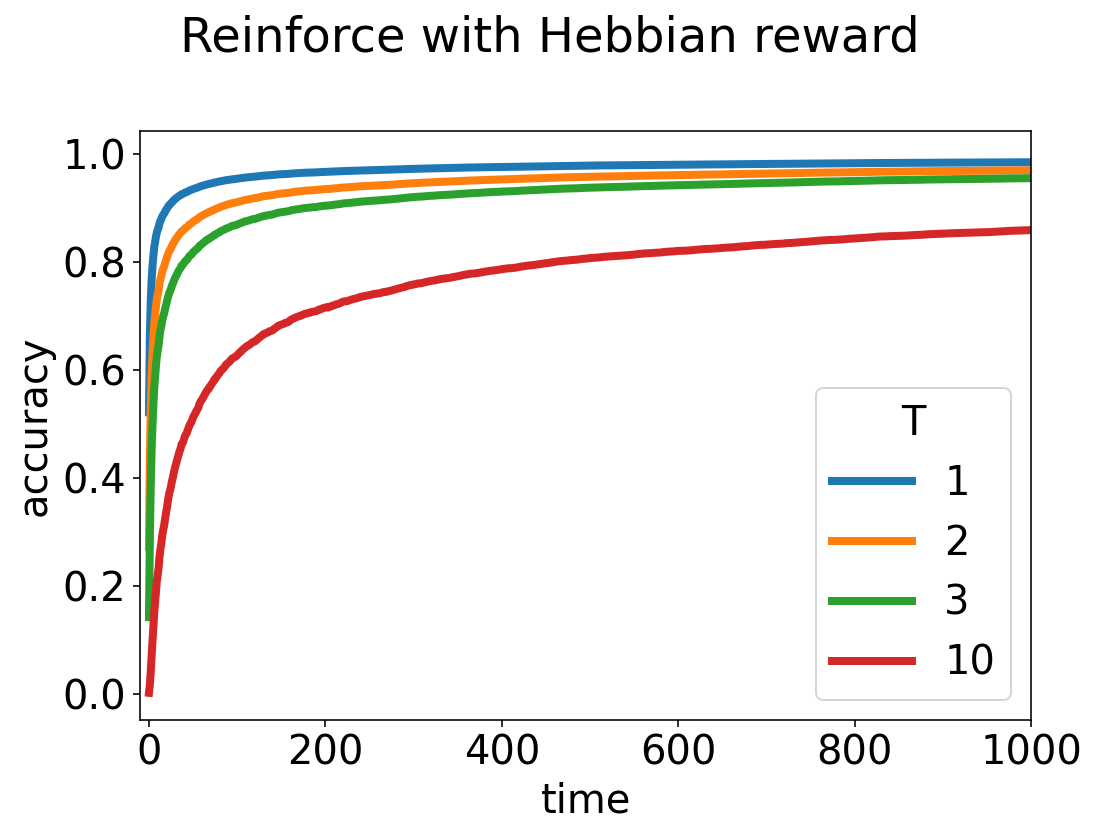

In [9]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("Reinforce with Hebbian reward")
for T in Ts:
    ax.plot(np.array(steps_rl_sim) / D, accuracies_rl_sim[T], label=T)
# ax.plot(np.array(steps_sim) / D, accuracies_sim["perceptron"], "--", color="C0", label="Perceptron")
ax.legend(title="T")
ax.set_xlabel("time")
ax.set_xlim(left=-10, right=1000)
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [11]:
"""
ODEs original case
"""
Q = dict()
R = dict()
w = copy.deepcopy(w_rl_init)

# Initial conditions for the order parameters
for T in Ts:
    Q[T] = w_rl_init[T] @ w_rl_init[T] / D
    R[T] = w_rl_init[T] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode = dict()
accuracies_w_update = dict()
for T in Ts:
    accuracies_rl_ode[T] = []
    accuracies_w_update[T] = []
R_rl_ode = copy.deepcopy(accuracies_rl_ode)    
Q_rl_ode = copy.deepcopy(accuracies_rl_ode)

dt = 1 / D

while step < num_steps:
    for T in Ts:
        # compute the probability that one, all-but-one, or all predictions were correct
        p_correct = (1 - 1 / np.pi * np.arccos(R[T] / W * np.sqrt(D/Q[T])))
        p_correct_all = p_correct**T
        unit_student = w[T]/np.linalg.norm(w[T])
        
        phi_2 = (np.pi - np.arccos(unit_student@unit_teacher))/2
        phi_1 = (np.pi - np.arccos(R[T] / W *np.sqrt(D/Q[T])))/2

        C_2 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        C_1 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + R[T]/W * np.sqrt(D/Q[T]))

        dR = lr * W*C_1/np.sqrt(2*D) * p_correct_all * half_overlap
        
        dQ = lr * (np.sqrt(2/D)* C_1 * np.sqrt(D*Q[T]) * half_overlap + lr/T + 2*lr*(T-1)*C_1**2/(D*T))*p_correct_all
        
        dw = lr * np.sqrt(D)*C_2*test_accuracy(w[T], w_teacher, T) * (unit_teacher + unit_student)/np.linalg.norm(unit_teacher + unit_student)
        
        """dR = 1 / np.sqrt(2 * np.pi) * (1 + R[T] / np.sqrt(Q[T])) * p_correct_others
        dQ = (np.sqrt(2 / np.pi) * (np.sqrt(Q[T]) + R[T]) * p_correct_others
              + lr / T * p_correct_all)
        """
        R[T] += dt * dR
        Q[T] += dt * dQ
        w[T] += dt * dw
        
    if step % D == 0:
        steps_rl_ode += [step]
        for T in Ts:
            accuracies_rl_ode[T] += [test_accuracy_op(Q[T], R[T], T)]
            accuracies_w_update[T] += [test_accuracy(w[T], w_teacher, T)]
            R_rl_ode[T] += [R[T]]
            Q_rl_ode[T] += [Q[T]]
    step += 1




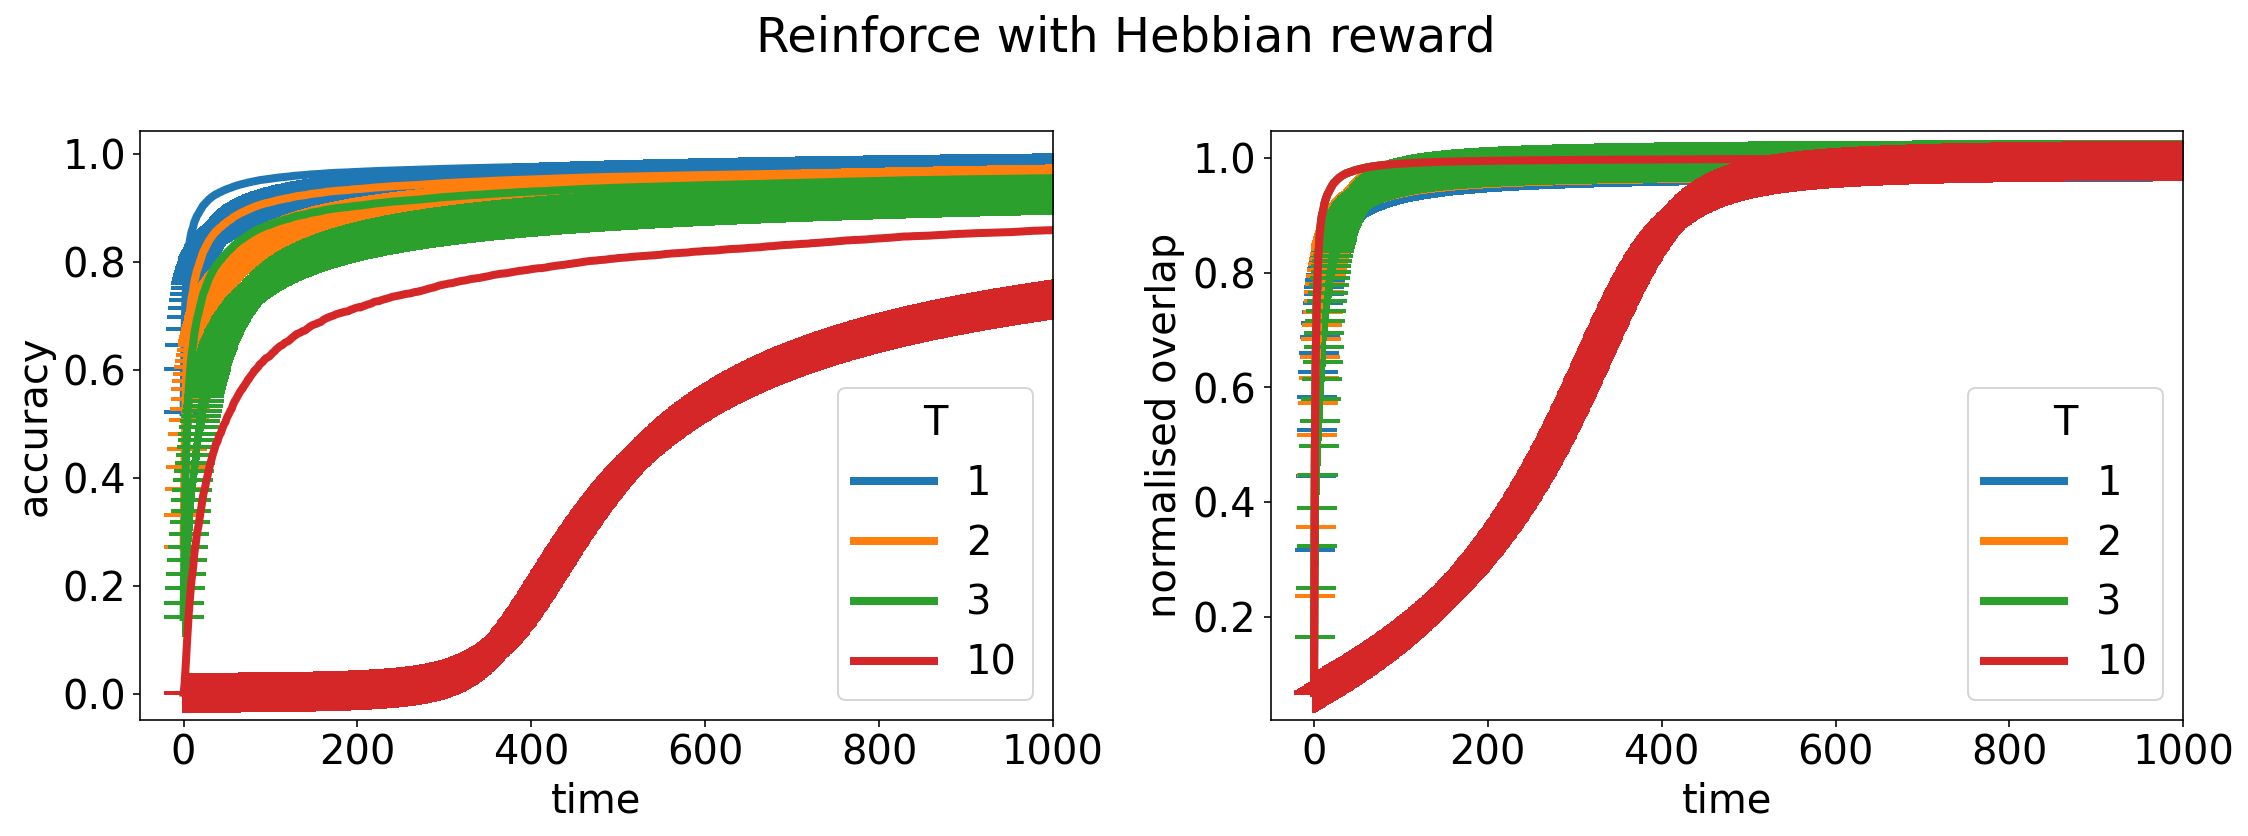

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(4 /3 * 2 * fig_size, fig_size))
fig.suptitle("Reinforce with Hebbian reward")

time_sim = np.array(steps_rl_sim) / D
time_ode = np.array(steps_rl_ode) / D

for T_idx, T in enumerate(Ts):
    color = "C" + str(T_idx)
    axes[0].plot(time_sim, accuracies_rl_sim[T], label=T, color=color)
    axes[0].plot(time_ode, accuracies_rl_ode[T], "+", color=color)
    
    axes[1].plot(time_sim, R_rl_sim[T] / np.sqrt(Q_rl_sim[T]), label=T, color=color)
    axes[1].plot(time_ode, R_rl_ode[T] / np.sqrt(Q_rl_ode[T]), "+", color=color)

axes[0].set_ylabel("accuracy")
axes[1].set_ylabel("normalised overlap")
for i in range(2):
    axes[i].set_xlim(left=-50, right=1000)
    axes[i].legend(title="T")
    axes[i].set_xlabel("time")
plt.tight_layout()
plt.show()

In [26]:
time_ode = np.array(steps_rl_ode) / D

ValueError: x and y must have same first dimension, but have shapes (5000,) and (0,)

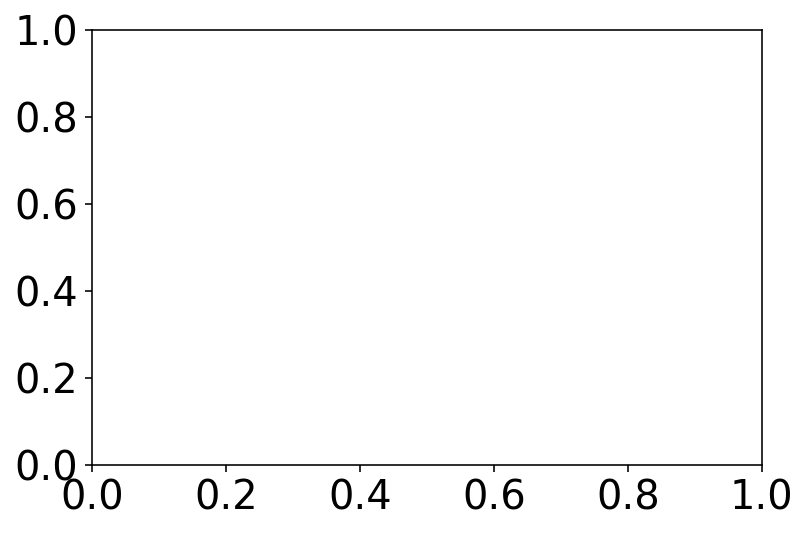

In [31]:
for T_idx, T in enumerate(Ts):
    color = "C" + str(T_idx)
    plt.plot(time_ode, accuracies_rl_ode[T], label=T, color=color)

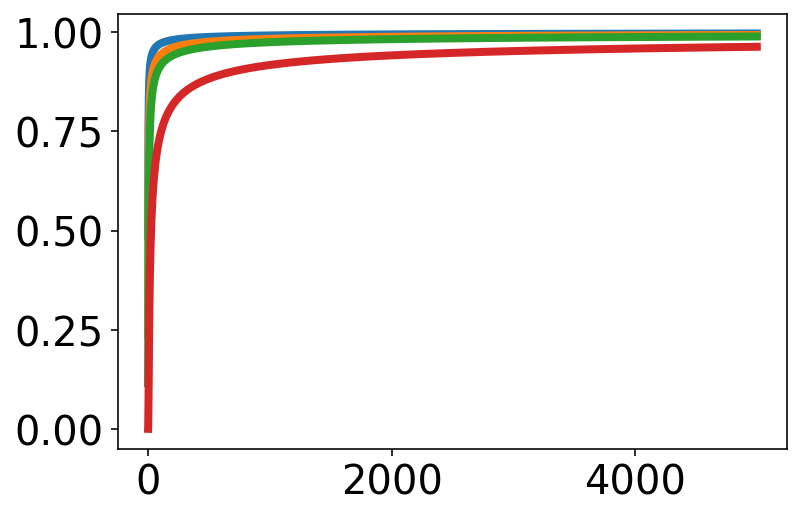

In [30]:
for T_idx, T in enumerate(Ts):
    color = "C" + str(T_idx)
    plt.plot(time_ode, accuracies_w_update[T], label=T, color=color)


In [ ]:
"""
Experimentation with update rule: only update if got first n or more correct
"""
Ts = [3, 10]
ns = {3:[2,3], 10:[6,8,10]}

# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student_2 = dict()
w_student_2 = rnd.randn(D)
for T in Ts:
    for n in ns[T]
    w_rl_student_2[(T,n)] = w_student_2
    
# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init_2 = copy.deepcopy(w_rl_student_2)

step = 0
num_steps = 5000 * D

steps_rl_sim = []
accuracies_rl_sim_2 = dict()
for T in Ts:
    for n in ns[T]
    accuracies_rl_sim_2[(T,n)] = []
R_rl_sim_2 = copy.deepcopy(accuracies_rl_sim_2)
Q_rl_sim_2 = copy.deepcopy(accuracies_rl_sim_2)

while step < num_steps:
    for T in Ts:
        for n in ns[T]
            # sample new input, output pair
            xs = rnd.randn(T, D)
            ys = np.sign(w_teacher @ xs.T)

            ypred = np.sign(w_rl_student_2[(T,n)] @ xs.T)

            reward = np.all(ys[:n] == ypred[:n]) #this is the only differing line of code

            hebbian_update = np.mean(ys[:, None] * xs, axis=0)

            w_rl_student_2[(T,n)] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
        steps_rl_sim += [step]
        for T in Ts:
            accuracies_rl_sim_2[(T,n)] += [test_accuracy(w_rl_student_2[(T,n)], w_teacher, T)]
            R_rl_sim_2[(T,n)] += [w_teacher @ w_rl_student_2[(T,n)] / D]
            Q_rl_sim_2[(T,n)] += [w_rl_student_2[(T,n)] @ w_rl_student_2[(T,n)] / D]
            
    step += 1


In [ ]:
"""
ODEs: 2nd case, only update if got first n or more correct
"""


